In [54]:
%matplotlib inline

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model, Sequential
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras import optimizers
import seaborn as sns
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
import os
import glob

In [2]:
train_labels = pd.read_csv('train_labels.csv')
train_labels.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [3]:
y = train_labels.invasive.values

In [4]:
train_images = glob.glob('data/train/*.jpg')
print('Found {} images'.format(len(train_images)))

Found 2295 images


In [5]:
X = np.zeros((len(train_images), 224, 224, 3))
assert X.shape[0] == len(y)

In [6]:
for i in range(len(train_images)):
    filename = os.path.join('data', 'train', '{}.jpg'.format(i + 1))
    img = image.load_img(filename, target_size=(224, 224))
    x = image.img_to_array(img)
    assert x.shape == (224, 224, 3)
    X[i] = x

In [7]:
X = preprocess_input(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
base_model = VGG16(weights='imagenet', include_top=False,
                  input_shape=(224, 224, 3))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(
    inputs=base_model.input,
    outputs=add_model(base_model.output))
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.SGD(lr=1E-4, momentum=0.9),
    metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
from keras.preprocessing.image import ImageDataGenerator

In [22]:
batch_size = 32
epochs = 1

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
train_datagen.fit(X_train)

In [24]:
%%time

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
)

Epoch 1/1
53/53 [==============================] - 3107s - loss: 0.6480 - acc: 0.8137 - val_loss: 0.2228 - val_acc: 0.9129
CPU times: user 5h 9min 29s, sys: 19min 46s, total: 5h 29min 16s
Wall time: 51min 50s


In [27]:
loss_and_metrics = model.evaluate(X_test, y_test)

574/574 [==============================] - 321s    


In [25]:
model.save('model.h5')

In [28]:
print(loss_and_metrics)

[0.22284476349993451, 0.91289198481662759]


In [29]:
predictions = model.predict(X_test)

In [33]:
np.round(predictions[:10])

array([[ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.]], dtype=float32)

In [34]:
y_train[:10]

array([0, 0, 1, 0, 1, 1, 0, 1, 1, 0])

In [43]:
list(zip(np.round(predictions[:10]).ravel().astype(int), y_test[:10]))

[(1, 1),
 (0, 0),
 (1, 1),
 (0, 0),
 (1, 1),
 (0, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0)]

In [40]:
pred = np.round(predictions).ravel().astype(int)

In [52]:
true_pos = ((pred == 1) & (y_test == 1)).sum()
true_neg = ((pred == 0) & (y_test == 0)).sum()
false_pos = ((pred == 1) & (y_test == 0)).sum()
false_neg = ((pred == 0) & (y_test == 1)).sum()
confusion = np.array([[true_pos, false_pos], [false_neg, true_neg]])
print(confusion)

[[315   7]
 [ 43 209]]


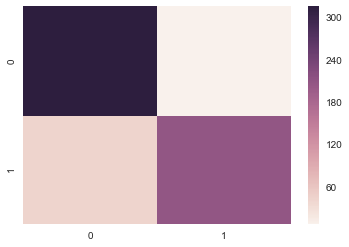

In [55]:
sns.heatmap(confusion)